# Загрузка библиотек

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif

from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score

# Загрузка и преобразование данных

In [2]:
# Загружаем данные
DATA_DIR = '/kaggle/input/sf-scoring/'
df_train = pd.read_csv(DATA_DIR +'/train.csv')
df_test = pd.read_csv(DATA_DIR +'/test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [3]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения default, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [4]:
df_train.shape

(73799, 20)

In [5]:
df_test.shape

(36349, 20)

In [6]:
sample_submission.shape

(36349, 2)

In [7]:
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,0
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,0


In [8]:
data.shape

(110148, 20)

In [9]:
# Проверим данные на пропуски
data.isnull().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

In [10]:
# Пропуски есть только признаке education, заменим их значением Unknown
data['education'] = data['education'].fillna('Unknown')

In [11]:
# Сделаем проверку на дублирующиеся строки
duplicate_rows_data = data[data.duplicated()]
print('Number of duplicate rows: ', duplicate_rows_data.shape[0])

Number of duplicate rows:  0


In [12]:
# Признак app_date переведем в формат datetime
datetime_list = []
for date in data['app_date'].values:
    datetime_list.append(datetime.strptime(date, '%d%b%Y'))

data['app_date'] = datetime_list

In [13]:
# Создадим новый признак - месяц подачи заявки
data['app_month'] = data['app_date'].dt.month
data['weekday'] = data['app_date'].apply(lambda d: d.weekday())

In [14]:
# Отсортируем признаки на числовые, категориальные и бинарные
num_cols = ['age', 'score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income']
cat_cols = ['education', 'first_time', 'sna', 'work_address', 'home_address', 'region_rating', 
            'app_month', 'weekday']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [15]:
# Отобразим каждое значение категории в уникальное число для бинарных и категориальных признаков
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
columns = ['first_time', 'sna', 'work_address', 'home_address', 'region_rating', 'app_month', 'weekday']

for column in columns:
    data[column] = label_encoder.fit_transform(data[column])

In [16]:
# Для колонки education создадим категориальный признак с помощью one-hot-кодирования
data = pd.get_dummies(data, columns=['education'])

In [17]:
# Проверим сбалансированность классов
count_no_def = len(data[data['default']==0])
count_def = len(data[data['default']==1])
pct_of_no_def = count_no_def/(count_no_def+count_def)
print("percentage of no default is", pct_of_no_def*100)
pct_of_def = count_def/(count_no_def+count_def)
print("percentage of subscription", pct_of_def*100)

percentage of no default is 91.49144787013836
percentage of subscription 8.508552129861641


Классы не сбалансированы, и соотношение не дефолных клиентов к дефолным составляет 91:8. Таким образом, качестве целевых метрик необходимо использовать F1-score.

In [18]:
data.drop(['client_id','app_date'], axis = 1, inplace=True)

# Очистка данных и выбор признаков

In [19]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'default'], axis=1)

Рассмотрим распределение числовых признаков. Так как у некоторых признаков в распределении есть большие перепады, возьмем от всех признаков натуральный логарифм.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


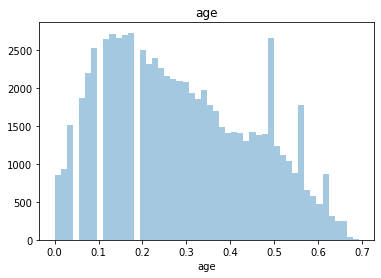

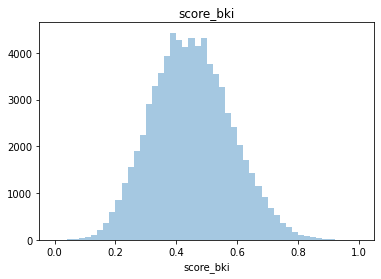

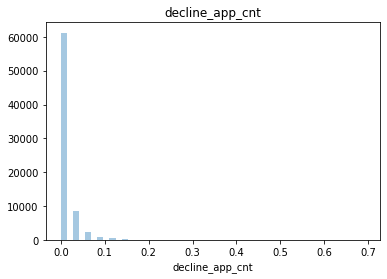

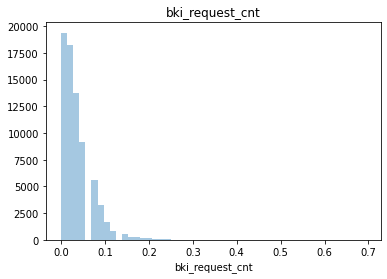

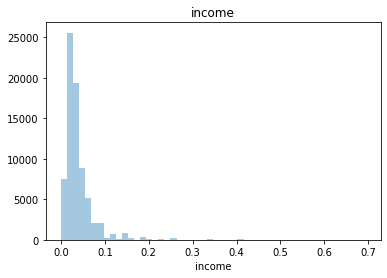

In [20]:
# Нормализуем признаки
for column in num_cols:
    train_data[column]=(train_data[column]-train_data[column].min())/(train_data[column].max()-
                                                                      train_data[column].min())
# Логарифмируем    
columns = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
for column in columns:
    train_data[column] = train_data[column].apply(lambda w: np.log(w+1))
    
# Строим распределение
for i in num_cols:
    plt.figure()
    sns.distplot(train_data[i], kde = False, rug=False)
    plt.title(i)
    plt.show()

Данные признака decline_app_cnt в основном содержат нули, имеет смысл перевести признак в категориальный.

In [21]:
train_data['decline_app_cnt'] = train_data['decline_app_cnt'].apply(lambda x: 0.0 if x == 0.0 
                                                                    else 1.0 if x <= 0.087011 
                                                                    else 2.0 if x > 0.087011 else x)

Рассмотрим выбросы в данных.

In [22]:
def outliers(col):
    '''Функция предназначена для выявления выбросов в числовых переменных'''
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    f = Q1 - 1.5*IQR
    l = Q3 + 1.5*IQR
    
    list_for_outliers = []
    num = 1
    for i in col:
        if (i > l) or (i < f):
            list_for_outliers.append(1)
        else:
            list_for_outliers.append(0)
    
    if num in list_for_outliers:
        return list_for_outliers
    else: 
        return 'no outliers'
    
outliers_age = outliers(train_data['age'])
outliers_score = outliers(train_data['score_bki'])
lst_outliers_req = outliers(train_data['bki_request_cnt'])
lst_outliers_inc = outliers(train_data['income'])

In [23]:
# Создадим новые признаки, отображающие выбросы в данных
train_data['bki_request_cnt_outl'] = lst_outliers_req
train_data['income_outl'] = lst_outliers_inc
train_data['score_bki_outl'] = outliers_score

In [24]:
# Заменим выбросы в данных
def rep_outliers(col):
    '''Функция предназначена для замены выбросов в числовых переменных'''
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    f = Q1 - 1.5*IQR
    l = Q3 + 1.5*IQR

    outliers = (col < f) | (col > l)

    col = col.copy()
    col.loc[col < f] = col.loc[~outliers].min()
    col.loc[col > l] = col.loc[~outliers].max()

    return col

cols = ['income', 'bki_request_cnt', 'score_bki']

for i in cols:
    train_data[i] = rep_outliers(train_data[i])

In [25]:
num_cols = ['age', 'score_bki', 'bki_request_cnt', 'income']
cat_cols = ['first_time', 'sna', 'work_address', 'home_address', 'region_rating', 
            'app_month', 'decline_app_cnt', 'weekday']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'education_ACD', 'education_GRD', 
            'education_PGR', 'education_SCH', 'education_UGR', 'education_Unknown',
            'bki_request_cnt_outl', 'income_outl', 'score_bki_outl']

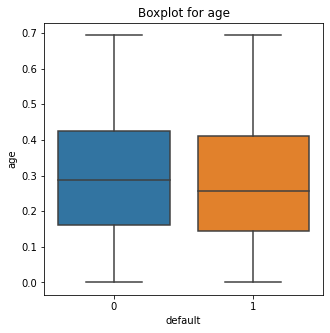

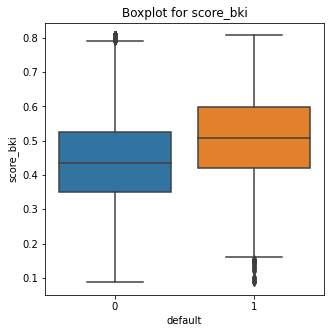

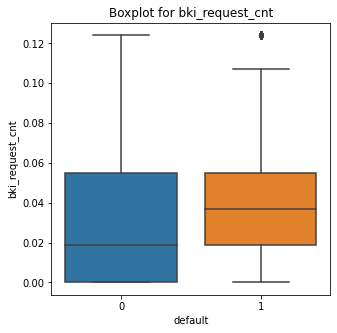

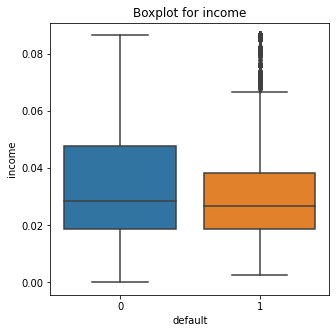

In [26]:
def get_boxplot(column):
    '''Функция предназначена для построения боксплота от целевой переменной'''
    fig, ax = plt.subplots(figsize = (5,5))
    sns.boxplot(x='default', y=column, data=train_data, ax=ax)
    ax.set_title('Boxplot for ' + column)
    plt.show()
    
for col in num_cols:
    get_boxplot(col)

Дефолтные клиенты в среднем немного младше. Дефолтные клиенты в среднем имеют больше запросов в БКИ. Дефолтные клиенты в среднем имеют более низкий доход.

<AxesSubplot:>

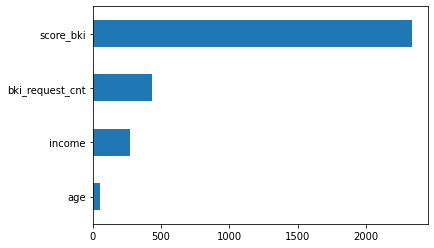

In [27]:
# Оценка значимости численных переменных
imp_num = pd.Series(f_classif(train_data[num_cols], train_data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Из числовых признаков наименьшую значимость имеет признак возраста.

<AxesSubplot:>

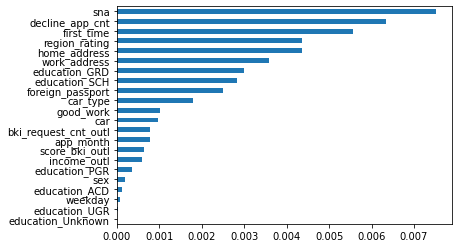

In [28]:
# Оценка значимости категориальных и бинарных признаков
imp_cat = pd.Series(mutual_info_classif(train_data[bin_cols + cat_cols], train_data['default'],
                                     discrete_features = True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Из бинарных и категориальных наименее значимыми являются пропуски в колонке education, education_UGR, education_ACD и sex.

<AxesSubplot:>

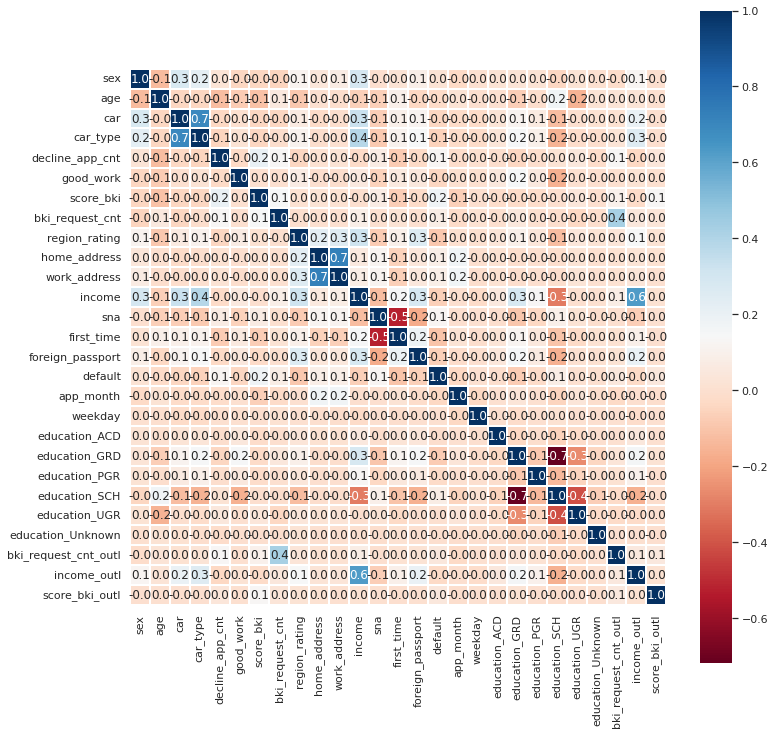

In [29]:
# Сделаем проверку на мультиколлинеарность. 
# Для этого построим матрицу корреляций для признаков:
sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(train_data.corr(), square=True, annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

Из корреляционной таблицы видно, что коррелируют признаки work_address и home_address, также данные признаки немного коррелируют с region_raiting. Сильная корреляция также есть между признаками car и car_type, между education_SCH и education_GRD, и между first_time и sna. С целевой переменной больше всего коррелируют признаки score_bki, decline_app_cnt, bki_request_cnt, region_rating, work_address и home_address, sna, first_time, foreign_passport, education_GRD и education_SCH.
Очевидно, что линейно зависимые и наименее значимые признаки нужно удалить из датасета, но перед этим проанализируем некоторые малозначимые признаки графически.

<AxesSubplot:xlabel='education_PGR'>

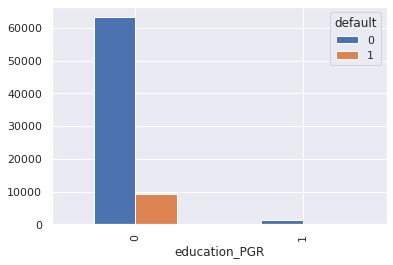

In [30]:
pd.crosstab(train_data.education_PGR,train_data.default).plot(kind='bar')

In [31]:
default_group = train_data.groupby('default')
default_group.education_PGR.value_counts(normalize = True)

default  education_PGR
0        0                0.981747
         1                0.018253
1        0                0.991357
         1                0.008643
Name: education_PGR, dtype: float64

<AxesSubplot:xlabel='education_ACD'>

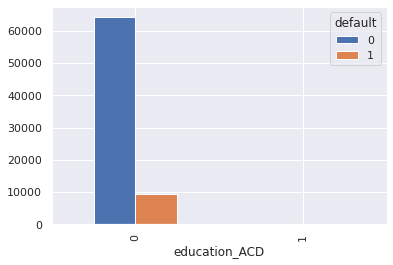

In [32]:
pd.crosstab(train_data.education_ACD,train_data.default).plot(kind='bar')

In [33]:
default_group.education_ACD.value_counts(normalize = True)

default  education_ACD
0        0                0.997113
         1                0.002887
1        0                0.999146
         1                0.000854
Name: education_ACD, dtype: float64

В случае характеристик education_PGR и education_ACD, в данных присутствет очень сильный перевес, поэтому оставим только один из этих признаков.

In [34]:
# Исходя из анализа выше, удалим признаки, которые имеют наименьшую значимость или имеют линейную зависимость.
train_data.drop(['age', 'car', 'work_address', 'education_UGR', 'education_ACD', 'education_Unknown', 
                 'income_outl', 'weekday'], axis = 1, inplace=True)

In [35]:
# Обновление категорирования для столбцов 
num_cols = ['score_bki', 'bki_request_cnt', 'income']
cat_cols = ['first_time', 'sna', 'home_address', 'region_rating', 'decline_app_cnt', 'app_month']
bin_cols = ['sex', 'car_type', 'good_work', 'foreign_passport', 'education_GRD', 'education_PGR','education_SCH',
            'bki_request_cnt_outl', 'score_bki_outl']

In [36]:
# Воспользуемся dummy-кодированием для категориальных переменных 
for column in cat_cols:
    train_data = pd.get_dummies(train_data, columns=[column])
    
# Стандартизация числовых переменных
scaler = StandardScaler()
train_data[num_cols] = scaler.fit_transform(train_data[num_cols])

# Построение модели

In [37]:
y = train_data['default'].values  # наш таргет
X = train_data.drop(['default'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# проверяем
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((59039, 37), (14760, 37), (59039,), (14760,))

In [38]:
# запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой останова tol1e-3
# чтобы получить оптимальные параметры модели в первом приближении
import warnings
warnings.filterwarnings("ignore")

iter_ = 50
epsilon_stop = 1e-3
logreg = LogisticRegression()

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

gridsearch = GridSearchCV(logreg, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
logreg = gridsearch.best_estimator_

#печатаем параметры
best_parameters = logreg.get_params()
for param_name in sorted(best_parameters.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1360, in fit
    sample_weight=sample_weight)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py", line 931, in _fit_liblinear
    y=y)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/class_weight.py", line 64, in compute_class_weight
    " got: %r" % class_weight)
ValueError: class_weight must be dict, 'balanced', or None, got: 'none'

  FitFail

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'ovr'
	n_jobs: None
	penalty: 'l2'
	random_state: None
	solver: 'sag'
	tol: 0.001
	verbose: 0
	warm_start: False


In [39]:
logreg = LogisticRegression(solver='sag', penalty='l2', class_weight='balanced', C = 1.0, max_iter=50,
                            multi_class='auto', tol=0.001)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [40]:
# метрики качества
def print_logisitc_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'acc = {acc:.3f} F1-score = {f1:.6f} prec = {prec:.2f} rec = {rec:.2f}')
print_logisitc_metrics(y_test, y_pred)

acc = 0.673 F1-score = 0.340298 prec = 0.23 rec = 0.68


In [41]:
from sklearn.metrics import classification_report
classification_report = classification_report(y_test, y_pred)
print(classification_report)

              precision    recall  f1-score   support

           0       0.94      0.67      0.78     12933
           1       0.23      0.68      0.34      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.68      0.56     14760
weighted avg       0.85      0.67      0.73     14760



In [42]:
confusion_matrix(y_test, y_pred)

array([[8683, 4250],
       [ 581, 1246]])

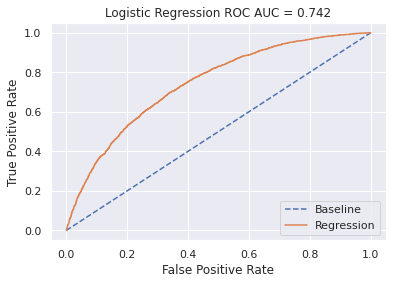

In [43]:
# Посмотрим ROC кривую
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [44]:
# Делаем те же манипуляции с тестовыми данными
num_cols = ['age', 'score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income']
for column in num_cols:
    test_data[column]=(test_data[column]-test_data[column].min())/(test_data[column].max()-
                                                                      test_data[column].min())
    
columns = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
for column in columns:
    test_data[column] = test_data[column].apply(lambda w: np.log(w+1))
    
test_data['decline_app_cnt'] = test_data['decline_app_cnt'].apply(lambda x: 0.0 if x == 0.0 
                                                                    else 1.0 if x <= 0.087011 
                                                                    else 2.0 if x > 0.087011 else x)

test_data['bki_request_cnt_outl'] = outliers(test_data['bki_request_cnt'])
test_data['income_outl'] = outliers(test_data['income'])
test_data['score_bki_outl'] = outliers(test_data['score_bki'])

cols = ['income', 'bki_request_cnt', 'score_bki']
for i in cols:
    test_data[i] = rep_outliers(test_data[i])

test_data.drop(['age', 'car', 'work_address', 'education_UGR', 'education_ACD', 'education_Unknown', 
                'income_outl', 'weekday'], axis = 1, inplace=True)

cat_cols = ['first_time', 'sna', 'home_address', 'region_rating', 'decline_app_cnt', 'app_month']
for column in cat_cols:
    test_data = pd.get_dummies(test_data, columns=[column])

# Стандартизация числовых переменных
num_cols = ['score_bki', 'bki_request_cnt', 'income']
test_data[num_cols] = scaler.transform(test_data[num_cols])

In [45]:
# если качество нас устраивает, обучаем финальную модель на всех обучающи данных
logreg_final = LogisticRegression(solver='sag', penalty='l2', class_weight='balanced', C = 1.0, max_iter=50,
                                  multi_class='auto', tol=0.001)
logreg_final.fit(X, y)

LogisticRegression(class_weight='balanced', max_iter=50, solver='sag',
                   tol=0.001)

In [46]:
predict_submission = logreg_final.predict(test_data)

In [47]:
sample_submission['default'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,client_id,default
0,74835,0
1,17527,1
2,75683,0
3,26883,0
4,28862,0
5,99881,1
6,26630,1
7,79934,0
8,16605,0
9,105449,0


In [48]:
sample_submission.describe()

,client_id,default
count,36349.000000,36349.000000
mean,54945.647473,0.376847
std,31706.052195,0.484603
min,4.000000,0.000000
25%,27744.000000,0.000000
50%,54657.000000,0.000000
75%,82322.000000,1.000000
max,110148.000000,1.000000


In [49]:
!kaggle competitions submit -c sf-scoring -f ssubmission.csv -m "Message"
# !kaggle competitions submit your-competition-name -f submission.csv -m 'My submission message'

Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.7/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.7/site-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


# Вывод

* Была проведена очистка данных от пропущенных значений и выбросов, на основе которых были созданы новые признаки. 
* С помощью LabelEncoder, mutual_info_classif и корреляционной матрицы были отобраны признаки, наиболее сильно влияющие на предсказательную способность модели.
* С помощью GridSearchCV были подобраны оптимальные гиперпараметры модели и рассчитаны основые метрики.
* Была проведена попытка улучшить модель с помощью SMOTE, но модель хуже справлялась с ошибкой второго рода.
* Были получены оценки качества модели: F-МЕРА = 0.34357, ACCURACY =  0.673